In [1]:
from scipy.stats import (
    norm, binom, expon, t, chi2, pareto, ttest_1samp, ttest_ind, sem
)
from statsmodels.stats.api import CompareMeans, DescrStatsW
from statsmodels.stats.proportion import proportion_confint
import numpy as numpy
from seaborn import distplot
from matplotlib import pyplot
import seaborn

import sys
sys.path.append('.')

import warnings
warnings.filterwarnings("ignore")

In [2]:
def inverse_plot_colorscheme():
    import cycler
    def invert(color_to_convert):
        table = str.maketrans('0123456789abcdef', 'fedcba9876543210')
        return '#' + color_to_convert[1:].lower().translate(table).upper()
    update_dict = {}
    for key, value in pyplot.rcParams.items():
        if value == 'black':
            update_dict[key] = 'white'
        elif value == 'white':
            update_dict[key] = 'black'

    old_cycle = pyplot.rcParams['axes.prop_cycle']
    new_cycle = []
    for value in old_cycle:
        new_cycle.append({
            'color': invert(value['color'])
        })
    pyplot.rcParams.update(update_dict)
    pyplot.rcParams['axes.prop_cycle'] = cycler.Cycler(new_cycle)
    lec = pyplot.rcParams['legend.edgecolor']
    lec = str(1 - float(lec))
    pyplot.rcParams['legend.edgecolor'] = lec

In [3]:
inverse_plot_colorscheme()

# Лекция 4-5. t-test

На этой лекции мы продолжим изучать критерии для анализа средних значений выборок и познакомимся с новым критерием: t-test.

Попробуем решить следующую задачу.

> 📈 **Задача**
>
> В нашей компании хотят перейти с одной СУБД на другую. Главным критерием для перехода является "затраченное время в сутках на загрузку новых данных". Если раньше для ежедневного обновления базы требовалось в среднем 10 часов, то хочется найти новую СУБД, в которой все это будет происходить быстрее, чем за 7 часов.
>
> Для этого было принято решение перенести все данные на новую тестируемую СУБД. В течение одной недели каждый день мы посчитаем время загрузки данных, и если в среднем на обновление будет уходить меньше 7 часов, то мы полностью перейдем на новую СУБД. Ваша задача придумать, как проверить гипотезу о том, что новая СУБД лучше старой.
> ___
> *СУБД - система управления базами данных*
>
> *БД - база данных*

Получилась выборка:

- `[6.9, 6.45, 6.32, 6.88, 6.19, 7.13, 6.76]` &mdash; время загрузки в новую БД по дням в часах.

Для начала переформулируем условие на языке математики: есть выборка
- $X_1, X_2, ..., X_7$ &mdash; время загрузки в часах новых данных в СУБД за каждый день эксперимента
- Еще будем считать, что $X$ из нормального распредения.

In [4]:
X = numpy.array([6.9, 6.45, 6.32, 6.88, 6.09, 7.13, 6.76])
print(f"Среднее время загрузки в СУБД: {round(numpy.mean(X), 2)}")

Среднее время загрузки в СУБД: 6.65


Наша гипотеза звучит так:

$H_0$: $E \overline{X} \geq 7\ vs.\ H_1: E \overline{X} < 7$



Кажется, что мы такое уже умеем решать: вспомним про z-критерий.

---
**Z-критерий**

$H_0: \mu \leq \mu_0\ vs.\ H_1: \mu > \mu_0$
- Статистика $Z(X) = \sqrt{n}\dfrac{\overline X - \mu_0}{\sqrt{\sigma^2}}$
- При достаточно большом размере выборки $Z(X) \overset{H_0}{\sim} \mathcal{N}(0, 1)$ (по ЦПТ)
- Односторонний критерий: $\left\{Z(X) \geq z_{1 - \alpha} \right\}$
    - p-value = $1 - \Phi(z)$, где z &mdash; реализация статистики $Z(X)$, $\Phi(z)$ &mdash; функция распределения $\mathcal{N}(0, 1)$
- Двусторонний критерий: $\left\{Z(X) \geq z_{1 - \frac{\alpha}{2}} \right\} \bigcup \left\{Z(X) \leq -z_{1 - \frac{\alpha}{2}} \right\} $
    - p-value = $2\cdot \min \left[{\Phi(z), 1 - \Phi(z)} \right]$, где z &mdash; реализация статистики $Z(X)$
---

Тогда надо лишь посчитать следующую статистику: $\sqrt{n}\dfrac{\overline X - 7}{\sqrt{\sigma^2}} \overset{H_0}{\sim} \mathcal{N}(0, 1)$

**Но есть одна проблема: мы не знаем $\sigma^2$!**


Что мы можем сделать? Правильно, попытаемся ее оценить! Благо придумывать оценку не надо, ее уже придумали за нас: $\widehat{\sigma^2} =S^2 = \dfrac{1}{n - 1}\underset{i=1}{\overset{n}{\sum}}(X_i - \overline X)^2$. Она является [несмещенной](https://ru.wikipedia.org/wiki/Несмещённая_оценка) и [состоятельной](https://ru.wikipedia.org/wiki/Состоятельная_оценка) оценкой дисперсии.

In [6]:
X = numpy.array([5.9, 2.45, 3.32, 6.88, 3.09, 8.13, 3.76])

# ddof = 1 -- Это значит, что делим не на n, а на n-1 в формуле выше
# ddof - delta degrees of freedom
print(f"Оценка sigma^2: {numpy.var(X, ddof=1)}")

Оценка sigma^2: 4.723866666666668


Давайте введем новый критерий T'-test, в котором мы подставим:

- $T(X) := \sqrt{n}\dfrac{\overline X - \mu_0}{\sqrt{S^2}} $
- $T(X) \overset{H_0}{\sim} \mathcal{N}(0, 1)$

    
Осталось проверить: **Правда ли что при $H_0$ распределение статистики T &mdash; стандартное нормальное?**


Для этого я предлагаю посмотреть, как на самом деле будет распределена статиcтика $T(X) = \sqrt{n}\dfrac{\overline{X}-\mu_0}{\sqrt{S^2}}$ в задаче, поставленной изначально.
Для этого будем считать, что выборка $X$ состоит из 7 элементов и $X \sim \mathcal{N}$.

- Мы $M$ раз нагенерируем выборку $X$ и посчитаем каждый раз статиcтику $T(X)$.
- В итоге мы получим выборку размера $M$ для $T(X)$ и сможем построить гистограмму распределения. Отдельно построим распределение $\mathcal{N}(0, 1)$. Если эмпирическое распределение визуально совпадет с теоретическим нормальным, значит все хорошо. А если нет, то так просто мы не можем заменить $\sigma^2$ на $S^2$.
    - Дополнительно посмотрим, что будет, если заменить $T(X)$ на $Z(X)$. Благо на искусственном примере мы знаем дисперсию.

Для этого мы напишем единообразную функцию, которая сможет построить распределение для любой статистики, а не только для $T(X), Z(X)$.

In [8]:
def sample_statistics(number_of_experiments, statistic_function, sample_size, sample_distr):
    """
        Функция для генерации выборки некой статистики statistic_function, построенной по выборке из распределения sample_distr.
        Возвращает выборку размера number_of_experiments для statistic_function.

        Праметры:
            - number_of_experiments: число экспериментов, в каждом из которых мы посчитаем statistic_function
            - statistic_function: статистика, которая принимает на вход выборку из распределения sample_distr
            - sample_size: размер выборки, которая подается на вход statistic_function
            - sample_distr: распределение изначальной выборки, по которой считается статистика
    """

    statistic_sample = []
    for _ in range(number_of_experiments):
        # генерируем number_of_experiments раз выборку
        sample = sample_distr.rvs(sample_size)

        # считаем статистику
        statistic = statistic_function(sample)

        #сохраняем
        statistic_sample.append(statistic)
    return statistic_sample

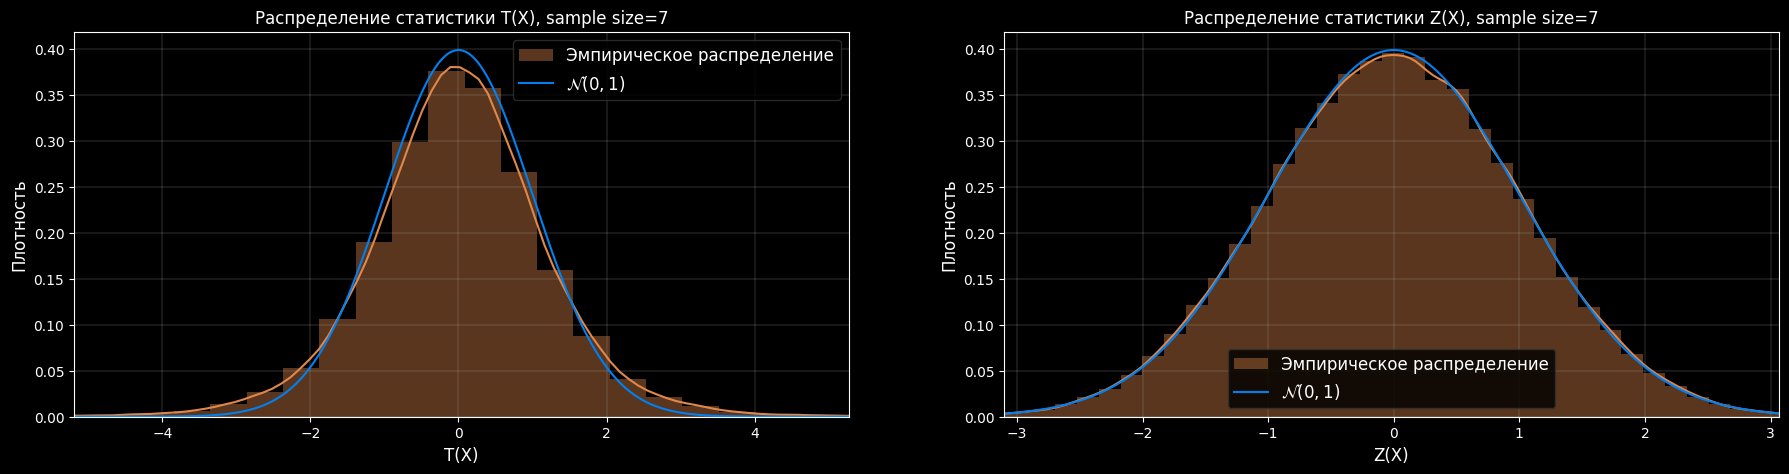

In [9]:
numpy.random.seed(8)

sample_size=7
M = 100000
sample_distr = norm(loc=5, scale=3) # Пусть выборка из этого распределения

# С использованием несмещенной состоятельной оценки std
T_X = lambda sample: numpy.sqrt(sample_size) * (numpy.mean(sample) - sample_distr.mean()) / numpy.sqrt(numpy.var(sample, ddof=1)) # или numpy.std
# С использоанием истинного значения std
Z_X = lambda sample: numpy.sqrt(sample_size) * (numpy.mean(sample) - sample_distr.mean()) / sample_distr.std() # истинное std

samples = {
    "T(X)": sample_statistics(
    number_of_experiments=M, statistic_function=T_X,
    sample_size=sample_size, sample_distr=sample_distr),

    "Z(X)": sample_statistics(
    number_of_experiments=M, statistic_function=Z_X,
    sample_size=sample_size, sample_distr=sample_distr)
}


pyplot.figure(figsize=(22, 5))

for i, name in enumerate(["T(X)", "Z(X)"]):
    pyplot.subplot(1, 2, i + 1)
    current_sample = samples[name]
    l_bound, r_bound = numpy.quantile(current_sample, [0.001, 0.999])

    x = numpy.linspace(l_bound, r_bound, 1000)
    pyplot.title(f'Распределение статистики {name}, sample size={sample_size}', fontsize=12)
    distplot(current_sample, label='Эмпирическое распределение')
    pyplot.plot(x, norm(0, 1).pdf(x), label='$\mathcal{N}(0, 1)$')
    pyplot.legend(fontsize=12)
    pyplot.xlabel(f'{name}', fontsize=12)
    pyplot.xlim((l_bound, r_bound))
    pyplot.ylabel('Плотность', fontsize=12)
    pyplot.grid(linewidth=0.2)

pyplot.show()

Мы видим, что:
- Z-test тут работает: $\sqrt{n}\dfrac{\overline X - \mu_0}{\sqrt{\sigma^2}} \sim \mathcal{N}(0, 1)$.
- Но вот для $T(X)$ это не так! **Они отличаются! А значит T'-критерий не подходит для изначальной задачи!**. Видим, что графики расходятся, причем хуже всего в хвостах. Хвосты в эмпирическом (истинном) распределении толще, чем для нормального распределения.   
  
Например, истинная вероятность того, что T-статистика окажется левее -3 или правее + 3 значительно больше, чем то, что мы оценим, если будем использовать нормальную аппроксимацию

----

### Почему такое произошло?

При создании критерия есть **2 шага**:
1. Придумать статистику для критерия
    - С этим мы успешно справились, придумав $T(X)$.
2. Понять, как распределена статистика.
    - И вот это самый сложный шаг, который не позволяет использовать любую придуманную статистику. Нужно также понимать ее распределение.
    - И с этим, как мы увидели, мы провалились для $T(X)$. Нормальное распределение не подошло.

Но почему $T(X) = \sqrt{n}\dfrac{\overline X - \mu}{\sqrt{S^2}}$ не распределена нормально, хотя $\sqrt{n}\dfrac{\overline X - \mu}{\sqrt{\sigma^2}} \overset{H_0}{\sim} \mathcal{N}(0, 1)$? Почему при замене $\sigma^2$ на $S^2$ все испортилось?

**Дело в том, что $S^2$ &mdash; это случайная величина!**

Вспомним, как мы выводили Z-критерий?
1. Мы посчитали, что $\overline X \sim \mathcal{N}(\mu, \sigma^2)$. Из ЦПТ или, в случае выше, из свойств нормального распределения.
2. Далее, все также из свойств этого распределения следует, что если мы вычтем константу или поделим на константу, то нормальное распределение не превратится в другое: поэтому $\sqrt{n}\dfrac{\overline X - \mu_0}{\sqrt{\sigma^2}} \sim \mathcal{N}(0, 1)$.

**Но мы ничего не знаем про** $\dfrac{\overline{X}}{\sqrt{\eta}}$, где $\overline{X} \sim \mathcal{N}, S^2 := \eta \sim P$, где P неизвестно. Мы не знаем пока никаких теорем, которые хоть как-то доказывали, что тут также останется нормальное распределение.

Давайте посмотрим на распределение $\sqrt{S^2}$ на все том же нормальном распределении.

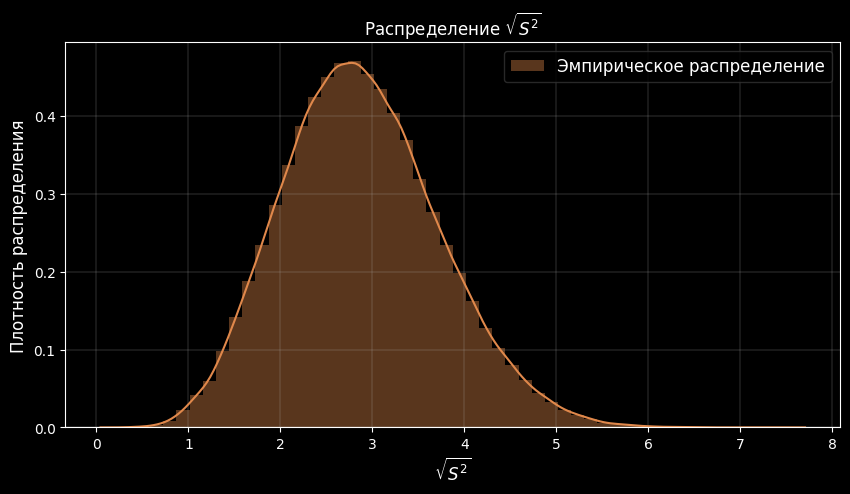

In [10]:
numpy.random.seed(42)


S2 = lambda sample: numpy.std(sample, ddof=1)
S2_sample = sample_statistics(
    number_of_experiments=M, statistic_function=S2,
    sample_size=sample_size, sample_distr=sample_distr
)

pyplot.figure(figsize=(10, 5))
pyplot.title('Распределение $\sqrt{S^2}$', fontsize=12)
distplot(S2_sample, label='Эмпирическое распределение')
pyplot.legend(fontsize=12)
pyplot.xlabel('$\sqrt{S^2}$', fontsize=12)
pyplot.ylabel('Плотность распределения', fontsize=12)
pyplot.grid(linewidth=0.2)
pyplot.show()

Мы видим, что оно не симметрично и непонятно как распределено. При этом самое частое значение даже не 3, а 2.6. Поэтому, когда мы некую величину из нормального распределения делим на несимметричное непонятное распределение, мы и получаем, что наша статистика $T$ не из нормального распределения.

Так что давайте выведем критерий, который поможет решить изначальную задачу!

**То есть T'-тест не верен, потому что мы часто недооцениваем истинную дисперсию => у нормальной аппроксимации хвосты гораздо тоньше, чем в истинном распределении**

## T-test

Давайте решим проблему шага 2 в создании критерия и найдем распределение статистики $T = \sqrt{n}\dfrac{\overline X - \mu_0}{\sqrt{S^2}}$. Для того, чтобы это узнать, нам потребуется несколько фактов:

1. Пусть $X_1 \ldots X_n \sim \mathcal{N}(\mu, \sigma^2)$

2. Пусть $\xi_1 \ldots \xi_n \sim \mathcal{N}(0, 1)$. Тогда $\eta=\xi_1^2 +\ ... +\xi_n^2 \sim \chi^2_n$, &mdash; [**хи-квадрат распределение с $n$ степенями свободы**](https://ru.wikipedia.org/wiki/Распределение_хи-квадрат).
    - Тогда $\underset{i=1}{\overset{n}{\sum}}\left(\xi_i - \overline \xi \right)^2 \sim \chi^2_{n-1}$. [Док-во](https://en.wikipedia.org/wiki/Cochran%27s_theorem) для крепких духом, и любящих линейную алгебру.

    - $S^2_X = \dfrac{1}{n - 1}\underset{i=1}{\overset{n}{\sum}}(X_i - \overline X)^2 $

    - $\xi_i := \dfrac{X_i - \mu}{\sigma} \sim \mathcal{N}(0, 1)$. Тогда $S^2_{\xi} = \dfrac{1}{\sigma^2}S^2_X$.
<!--     $$\begin{align}
    S^2_{\xi} &= \dfrac{1}{n - 1}\underset{i=1}{\overset{n}{\sum}}\left(\xi_i - \overline \xi \right)^2 =
            \dfrac{1}{n - 1}\underset{i=1}{\overset{n}{\sum}} \left(\dfrac{X_i-\mu}{\sigma} - \underset{i=1}{\overset{n}{\sum}}\left[\dfrac{X_i-\mu}{n\sigma}\right] \right)^2 = \\
             &= \dfrac{1}{n - 1}\underset{i=1}{\overset{n}{\sum}} \left(\dfrac{X_i}{\sigma} - \dfrac{\mu}{\sigma} - \underset{i=1}{\overset{n}{\sum}}\left[\dfrac{X_i}{n\sigma}\right] + \dfrac{n\mu}{n\sigma} \right)^2 =\\
             &= \dfrac{1}{n - 1}\underset{i=1}{\overset{n}{\sum}} \left(\dfrac{X_i}{\sigma} -\dfrac{\overline X_i}{\sigma} \right)^2 = \dfrac{1}{\sigma \cdot(n - 1)}\underset{i=1}{\overset{n}{\sum}} \left(X_i - \overline X_i \right)^2 = \dfrac{1}{\sigma}S^2_X
    \end{align}
    $$ -->
    
    - А значит $\dfrac{(n - 1)\cdot S^2_X}{\sigma^2} = \underset{i=1}{\overset{n}{\sum}}\left(\xi_i - \overline \xi \right)^2 \sim \chi^2_{n-1}$

3. Пусть $\xi \sim \mathcal{N}(0, 1), \eta \sim \chi^2_k$ и $\xi$ с $\eta$ независимы. Тогда статистика $\zeta = \dfrac{\xi}{\sqrt{\eta/k}} \sim t_{k}$ &mdash; из [распределения Стьюдента](https://ru.wikipedia.org/wiki/Распределение_Стьюдента) с k степенями свободы.

    - $\xi := \sqrt{n}\dfrac{\overline X - \mu_0}{\sigma} \sim \mathcal{N}(0, 1)$
    - $\eta := \dfrac{(n - 1)\cdot S^2_X}{\sigma^2} \sim \chi^2_{n-1}$
    - $\xi$ и $\eta$ [независимы](https://math.stackexchange.com/questions/4165803/overlinex-and-s2-are-independent)
    - Тогда
    $$\begin{align}
        T = \sqrt{n}\dfrac{\overline X - \mu_0}{\sqrt{S^2}} = \frac{\sqrt{n}\dfrac{\overline X - \mu_0}{\sigma}}{\sqrt{\dfrac{(n - 1)\cdot S^2_X}{(n - 1)\sigma^2}}} = \dfrac{\xi}{\sqrt{\dfrac{\eta}{n-1}}} \sim t_{n - 1}
    \end{align}$$

**Итого:**

Придуманная нами статистика $T = \sqrt{n}\dfrac{\overline X - \mu_0}{\sqrt{S^2}} \sim t_{n - 1}$ &mdash; взята из распределения Стьюдента с n - 1 степенью свободы. **Но только в случае, если изначальная выборка из нормального распределения!**

Теперь нам достаточно данных, чтобы построить критерий для нашей изначальной задачи:

### T-test, критерий

$H_0: \mu =\mu_0, X \sim \mathcal{N}\ vs.\ H_1: \mu > \mu_0$ или $X$ не из нормального распределения
- Статистика $T(X) = \sqrt{n}\dfrac{\overline X - \mu_0}{\sqrt{S^2}}$
- $T(X)  \sim t_{n - 1}$
- Односторонний критерий: $\left\{T(X) \geq t_{n-1, 1 - \alpha} \right\}$
    - p-value = $1 - \tau_{n-1}(z)$, где z &mdash; реализация статистики $T(X)$, $\tau_{n-1}(z)$ &mdash; функция распределения $t_{n - 1}$
- Двусторонний критерий: $\left\{T(X) \geq t_{n-1, 1 - \frac{\alpha}{2}} \right\} \bigcup \left\{T(X) \leq -t_{n-1, 1 - \frac{\alpha}{2}} \right\} $
    - p-value = $2\cdot \min \left[{\tau_{n-1}(z), 1 - \tau_{n-1}(z)} \right]$, где z &mdash; реализация статистики $T(X)$
---

Давайте теперь протестируем все наши теоретические исследования на практике!

#### Python-библиотеки:
- `scipy.stats.chi2(df=N)` &mdash; [библиотека](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2.html) для распределения хи-квадрат с N степенями свободы.
- `scipy.stats.t(df=N)` &mdash; [библиотека](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html) для распределения Стьюдента с N степенями свободы.
- `scipy.stats.ttest_1samp`  &mdash; [реализованный T-критерий](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_1samp.html) в Python


Для начала посмотрим на распределение Хи квадрат и на распределение $\eta$.

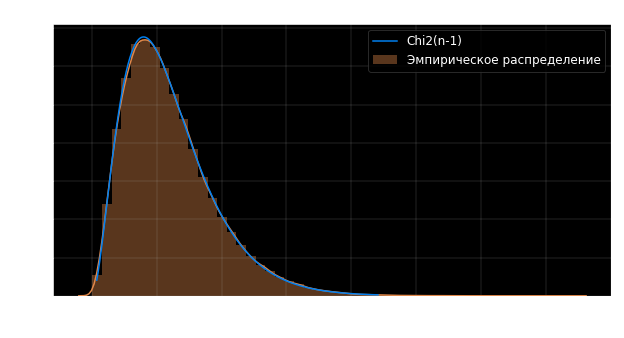

In [ ]:
numpy.random.seed(42)


eta_statistic = lambda sample: numpy.var(sample, ddof=1) * (sample_size - 1) / sample_distr.var()
eta_sample = sample_statistics(
    number_of_experiments=M, statistic_function=eta_statistic,
    sample_size=sample_size, sample_distr=sample_distr
)


chi2_dist = chi2(df=sample_size-1) # Распределение chi2

l_bound, r_bound = numpy.quantile(eta_sample, [0.001, 0.999])
x = numpy.linspace(l_bound, r_bound, 1000)

pyplot.figure(figsize=(10, 5))
pyplot.title('Распределение $\eta$', fontsize=12)
distplot(eta_sample, label='Эмпирическое распределение')
pyplot.plot(x, chi2_dist.pdf(x), label='Chi2(n-1)')
pyplot.legend(fontsize=12)
pyplot.xlabel('$\eta$', fontsize=12)
pyplot.ylabel('Плотность распределения', fontsize=12)
pyplot.grid(linewidth=0.2)
pyplot.show()

Видим, что все совпало!

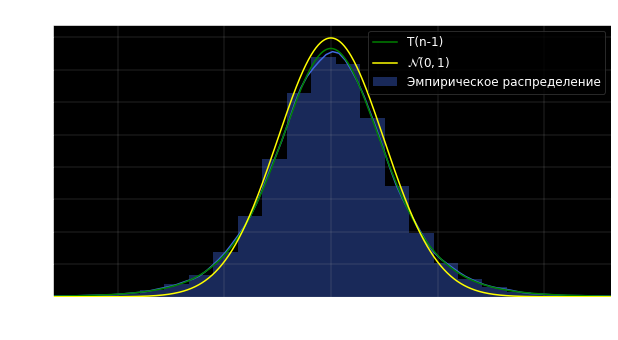

In [ ]:
numpy.random.seed(42)


T_X = lambda sample: numpy.sqrt(sample_size) * (numpy.mean(sample) - sample_distr.mean()) / numpy.std(sample, ddof=1)
T_sample = sample_statistics(
    number_of_experiments=M, statistic_function=T_X,
    sample_size=sample_size, sample_distr=sample_distr
)


T_dist = t(df=sample_size-1) # Распределение T Стьюдента

l_bound, r_bound = numpy.quantile(T_sample, [0.001, 0.999])
x = numpy.linspace(l_bound, r_bound, 1000)

pyplot.figure(figsize=(10, 5))
pyplot.title('Распределение $T(X)$', fontsize=12)
distplot(T_sample, color='royalblue', label='Эмпирическое распределение')
pyplot.plot(x, T_dist.pdf(x), c='green', label='T(n-1)')
pyplot.plot(x, norm(0, 1).pdf(x), c='yellow', label='$\mathcal{N}(0, 1)$')
pyplot.legend(fontsize=12)
pyplot.xlabel('$T(X)$', fontsize=12)
pyplot.ylabel('Плотность распределения', fontsize=12)
pyplot.xlim((l_bound, r_bound))
pyplot.grid(linewidth=0.2)
pyplot.show()

Здесь видно, что распределение Стьюдента практически идеально описывает данные, в то время как нормальное распределение более "центрировано": площадь в центре больше.

Теперь, как вызвать встроенный t-test в Питоне:


In [ ]:
# Как вызывать критерий
ttest_1samp(norm(loc=0, scale=1).rvs(100), popmean=-1, alternative='greater')

Ttest_1sampResult(statistic=11.510815172646131, pvalue=2.8759451265260583e-20)

### Доверительный интервал

Будет приведено 2 метода вывода доверительного интервала.

#### 1 метод

Вспомним определение из второй лекции:

> Пусть есть статистика $Q$ и критерий $\psi(Q)$ для проверки гипотезы $H_0: \theta = m$ уровня значимости $\alpha$.
>
> Тогда доверительный интервал для $\theta$ уровня доверия $1 - \alpha$: множество таких m, что критерий $\psi(Q)$ не отвергает для них $H_0$.


Пусть $\mu$ &mdash; истинное среднее выборки. Мы также знаем, что при $H_0: \sqrt{n}\dfrac{\overline X - m}{\sqrt{S^2}} \sim t_{n - 1}$.

Нас интересуют такие $m$, что:  $\left\{-t_{n-1, 1 - \frac{\alpha}{2}} < \sqrt{n}\dfrac{\overline X - m}{\sqrt{S^2}} < t_{n-1, 1 - \frac{\alpha}{2}} \right\}$, в этом случае критерий не отвергнется.

Распишем, чтобы в центре осталось только $m$: $\left\{\overline X - \dfrac{t_{n - 1, 1 - \alpha/2} \sqrt{S^2}}{\sqrt{n}} < m < \overline X + \dfrac{t_{n - 1, 1 - \alpha/2} \sqrt{S^2}}{\sqrt{n}}\right\}$. А значит наш доверительный интервал: $CI_{\mu} = \left(\overline X \pm \dfrac{t_{n - 1, 1 - \alpha/2} \sqrt{S^2}}{\sqrt{n}} \right),$ где $S^2 = \dfrac{1}{n - 1}\underset{i=1}{\overset{n}{\sum}}(X_i - \overline X)^2$.

### 2 метод

Докажем через [классическое определение](https://ru.wikipedia.org/wiki/Доверительный_интервал#Определение) доверительного интервала.

> Доверительным интервалом для параметра $\theta$ уровня доверия $1 - \alpha$ является пара статистик $L(X), R(X)$, таких, что $P(L(X) < \theta < R(X)) = 1 - \alpha$.

$$\begin{align}
    &T(X) = \sqrt{n}\dfrac{\overline X - \mu}{\sqrt{S^2}} \sim t_{n - 1} \Rightarrow \\
    &P\left(-t_{n - 1, 1-\alpha/2} < \sqrt{n}\dfrac{\overline X - \mu}{\sqrt{S^2}} < t_{n - 1, 1-\alpha/2} \right) = 1 - \alpha \Leftrightarrow \\
    &P\left(\overline X - \dfrac{t_{n - 1, 1 - \alpha/2} \sqrt{S^2}}{\sqrt{n}}  < \mu < \overline X + \dfrac{t_{n - 1, 1 - \alpha/2} \sqrt{S^2}}{\sqrt{n}} \right) = 1 - \alpha
\end{align}
$$


А значит $CI_{\mu} = \left(\overline X \pm \dfrac{t_{n - 1, 1 - \alpha/2} \sqrt{S^2}}{\sqrt{n}} \right)$.

*Как вы видите, доказательства в обоих случаях практически идентичны.*


В Питоне для построения есть специальная функция:

In [ ]:
sample = norm(loc=10, scale=2).rvs(100)

# sem -- standart error of the mean, sem = sqrt(S^2)/sqrt(n)
left_bound, right_bound = t.interval(alpha=0.95, loc=numpy.mean(sample), df=len(sample)-1, scale=sem(sample))
print(f"CI = [{round(left_bound, 2)}, {round(right_bound, 2)}]")

CI = [9.62, 10.39]


-----

Вернемся к изначальной задаче.
> 📈 **Задача**
>
> В нашей компании хотят перейти с одной СУБД на другую. Главным критерием для переходя является "затраченное время в сутках на загрузку новых данных". Если раньше для ежедневного обновления базы требовалось в среднем 10 часов, то хочется найти новую СУБД, в которой все это будет происходить бывстрее, чем за 7 часов.
>
> Для этого было принято решение перенести все данные на новую тестируемую СУБД. В течение одной недели каждый день мы посчитаем время загрузки данных, и если в среднем на обновление будет уходить меньше 7 часов, то мы полностью перейдем на новую СУБД. Ваша задача придумать, как проверить гипотезу о том, что новая СУБД лучше старой.

Получилась выборка:

- `[6.9, 6.45, 6.32, 6.88, 6.19, 7.13, 6.76]` &mdash; время загрузки в новую БД по дням в часах.

Для начала переформулируем условие на языке математики: есть выборка
- $X_1, X_2, ..., X_7$ &mdash; время загрузки в часах новых данных в СУБД за каждый день эксперимента
- Еще будем считать, что $X$ из нормального распредения.

$H_0$: $E \overline{X} \geq 7\ vs.\ H_1: E \overline{X} < 7$



Мы уже знаем, что если выборка нормальна, то мы можем использовать T-test. Тогда



In [11]:
X = numpy.array([6.9, 6.45, 6.32, 6.88, 6.09, 7.13, 6.76])

In [14]:
# посчитаем Т-тест руками
t_stat = (numpy.mean(X) - 7) / (numpy.var(X, ddof=1) / 7) ** 0.5
p_value = t(7-1).cdf(t_stat)
print(f't-stat = {t_stat}, p-value = {p_value}')

t-stat = -2.5247934680450737, p-value = 0.022497429172957096


In [12]:
# функция из библиотеки
ttest_1samp(X, popmean=7, alternative='less')

TtestResult(statistic=-2.524793468045073, pvalue=0.02249742917295711, df=6)

Мы видим, что на уровне значимости 2.5% критерий отвергся, а значит переход на новую СУБД удовлетворяет условиям: загрузка быстрее 7 часов!
Построим теперь доверительный интервал, чтобы понять, в каких границах у нас будет эффект.

In [ ]:
left_bound, right_bound = t.interval(alpha=0.95, loc=numpy.mean(X), df=len(X)-1, scale=sem(X))
print(f"CI = [{round(left_bound, 2)}, {round(right_bound, 2)}]")

CI = [6.31, 6.99]


Отлично! В среднем загрузка будет от 6 до 7 часов.

----

Так, мы научились решать задачу оценки среднего выборки, когда дисперсия неизвестна, но выборка из нормального распределения. Теперь научимся решать следующую задачу:


> 📈 **Задача**
>
> Вы придумали идею для стартапа в Москве, где курьеры собирают заказы для клиентов и отвозят им на дом. Маржа от заказа в вашем стартапе &mdash; X ₽, а стоимость работы курьера &mdash; 1К ₽.
Специфика вашего стартапа такова, что есть большой риск возврата без оплаты. С учетом стоимостей, инвесторы готовы проспонсировать вам инфраструктуру и привлечение клиентов, если вы покажете, что у вас будет прибыль.
>
> Из данных у вас есть принесенные деньги от каждого пользователя. Иногда положительная величина, иногда отрицательная.

Переформулируем задачу на языке статистики:
- $X_1, X_2, ..., X_N$ &mdash; выборка прибыли от пользователя.

$H_0$: $E \overline{X} \leq 0\ vs.\ H_1: E \overline{X} > 0$

Посмотрим на данные:

In [ ]:
profits = numpy.loadtxt('profit_from_user.out', delimiter=',')
print(profits[:100])

[-718.  657.  693.  391. -644.  421.  265. -108. 1956. -684. -753. -725.
 -341. -796. -662.  257. -719. 5184. -739. -291. -427.  283.   10.  500.
 -713. -458.   60. -756.  333. -537. -744.  254. -555. -780. -329. -560.
  936. -742. -784.  213.  299. -678. -736.   24.  264.  293. -490. 2667.
 -605. -799. -797. -743.  347. -718. -508. -766. 1395.  392.  -62. -510.
  237. -785. -745. -781. 3232. -727.  204. 2987.  244. -757.  -78.   10.
  364.   -7. -440.  520.  203.  282.  685.  589. -724.  -48.  263. -457.
 -796. -708. -798.  488. -677. -690.  786. -770.  659. -679. -309. -731.
  288. 1047. -796. -721.]


In [ ]:
print(f"average profit = {profits.mean()}")
print(f"n = {profits.shape[0]}")

average profit = 58.4868
n = 5000


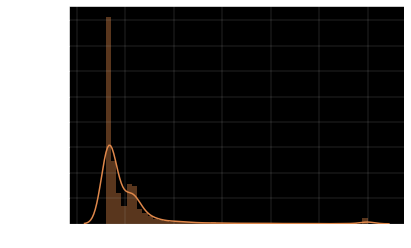

In [ ]:
seaborn.distplot(profits)
pyplot.grid(linewidth=0.2)


В отличие от предыдущей задачи тут 2 отличия:
- Изначальная выборка не из нормального распределения
- Выборка достаточно крупная: не 7 элементов, а уже 5000.

Так, а что мы уже умеем решать?


|                          | маленькая выборка | большая выборка |
|--------------------------|-------------------|-----------------|
| нормальное распределение | t-test            | t-test          |
| любое распределение      |                   |                 |

А сейчас мы выведем критерий для ячейки: "любое распределение, большая выборка". Мы снова будем выводить распределение для $T(X)$ статистики.


## T'-test

Вспомним, что у нас изначально была идея в Z-тесте вместо статистики Z, в которой дисперсия известна, использовать критерий T, где дисперсия оценена на данных. И использовать нормальное распределение. Только в первой задаче этот критерий нам не помог. Но что, если бы выборка была большой? Могли бы мы использовать нормальное распределение для приближения?


1. Будем рассматривать ту же статистику $T = \sqrt{n}\dfrac{\overline X - \mu_0}{\sqrt{S^2}}$
2. $\xi := \sqrt{n}\dfrac{\overline X - \mu_0}{\sqrt{\sigma^2}} \stackrel{d}{\rightarrow} \mathcal{N}(0, 1)$. По ЦПТ сходимость есть только по [распределению](https://en.wikipedia.org/wiki/Convergence_in_distribution).
3. Тогда $T = \sqrt{n}\dfrac{\overline X - \mu_0}{\sqrt{S^2}} = \xi \cdot \sqrt{\dfrac{\sigma^2}{S^2}}$. Обозначим $\phi := \sqrt{\dfrac{\sigma^2}{S^2}}$
    - Помните, в начале лекции было сказано, что $S^2$ &mdash; лучшая оценка для дисперсии? Все дело в том, что она является [состоятельной оценкой](https://ru.wikipedia.org/wiki/Состоятельная_оценка) $\sigma^2$. По-другому это можно записать так: $S^2$ [сходится по вероятности](https://en.wikipedia.org/wiki/Convergence_of_random_variables#Convergence_in_probability) к $\sigma^2$. То есть $S^2  \stackrel{p}{\rightarrow} \sigma^2$
    - А в этом случае существует [теорема](https://en.wikipedia.org/wiki/Continuous_mapping_theorem), утверждающая, что $\phi = \dfrac{\sigma^2}{S^2}  \stackrel{p}{\rightarrow} 1$.
4. $T = \xi \cdot \phi$.
    - $\xi \stackrel{d}{\rightarrow} \mathcal{N}(0, 1)$
    - $\phi  \stackrel{p}{\rightarrow} 1$
    - И тут вступает в силу еще одна [теорема](https://en.wikipedia.org/wiki/Slutsky%27s_theorem): $T = \xi \cdot \phi \stackrel{d}{\rightarrow} 1\cdot \mathcal{N}(0, 1)$. Та же сходимость, что и в ЦПТ!
    - **То есть статистика $T$ точно также нормально распределена!**
    
    
Итого, если выборка большая, то мы можем считать, что $T(X) \overset{H_0}{\sim} \mathcal{N}(0, 1)$.

---

Заметим, что в случае "нормальное распределение, большая выборка" работают сразу 2 критерия: t-test и t'-test. Это значит, что если $T(X) \overset{H_0}{\sim} t_{n - 1}$ и $T(X) \overset{H_0}{\sim} \mathcal{N}(0, 1)$, то $t_{n - 1} \approx \mathcal{N}(0, 1)$.
- Формально же, если степень свободы в t-распределении равна бесконечности, то это нормальное распределение! $\lim_{n\rightarrow \infty}t_{n} = \mathcal{N}(0, 1)$

А если $t_{n - 1} \approx \mathcal{N}(0, 1)$, то мы вместо T'-критерия мы можем использовать T-критерий! **Из того, что мы теоретически можем использовать T'-test, на практике мы можем использовать и T-test!**

---

А значит мы заполнили еще 1 ячейку в таблице:

|                          | маленькая выборка | большая выборка |
|--------------------------|-------------------|-----------------|
| нормальное распределение | t-test            | t-test, t'-test |
| любое распределение      |                   | t'-test, t-test |


### T'-test, критерий

$H_0: \mu =\mu_0\ vs.\ H_1: \mu > \mu_0$
- Статистика $T(X) = \sqrt{n}\dfrac{\overline X - \mu_0}{\sqrt{S^2}}$
- При достаточно большом размере выборки $T(X) \overset{H_0}{\sim} \mathcal{N}(0, 1)$ (по ЦПТ и куче вспомогательных теорем)
- Односторонний критерий: $\left\{T(X) \geq z_{1 - \alpha} \right\}$
    - p-value = $1 - \Phi(z)$, где z &mdash; реализация статистики $T(X)$, $\Phi(z)$ &mdash; функция распределения $\mathcal{N}(0, 1)$
- Двусторонний критерий: $\left\{T(X) \geq z_{1 - \frac{\alpha}{2}} \right\} \bigcup \left\{T(X) \leq -z_{1 - \frac{\alpha}{2}} \right\} $
    - p-value = $2\cdot \min \left[{\Phi(z), 1 - \Phi(z)} \right]$, где z &mdash; реализация статистики $Z(X)$
---


Проверим наш критерий на крупных выборках:

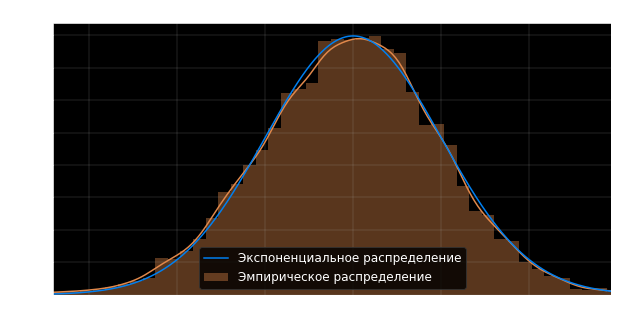

In [ ]:
numpy.random.seed(8)

sample_size=2000
M = 10000
sample_distr = expon(loc=5, scale=300)

T_X = lambda sample: numpy.sqrt(sample_size) * (numpy.mean(sample) - sample_distr.mean()) / numpy.std(sample, ddof=1)
T_sample = sample_statistics(
    number_of_experiments=M, statistic_function=T_X,
    sample_size=sample_size, sample_distr=sample_distr)

pyplot.figure(figsize=(10, 5))
l_bound, r_bound = numpy.quantile(T_sample, [0.001, 0.999])


x = numpy.linspace(l_bound, r_bound, 1000)
pyplot.title(f'Распределение статистики T(X), sample size={sample_size}', fontsize=12)
distplot(T_sample, label='Эмпирическое распределение')
pyplot.plot(x, norm(0, 1).pdf(x), label='Экспоненциальное распределение')
pyplot.legend(fontsize=12)
pyplot.xlabel(f'{name}', fontsize=12)
pyplot.xlim((l_bound, r_bound))
pyplot.ylabel('Плотность', fontsize=12)
pyplot.grid(linewidth=0.2)
pyplot.show()

Мы видим, что распределения совпали! А на нормальном распределении, где в первый раз были различия на маленькой выборке?

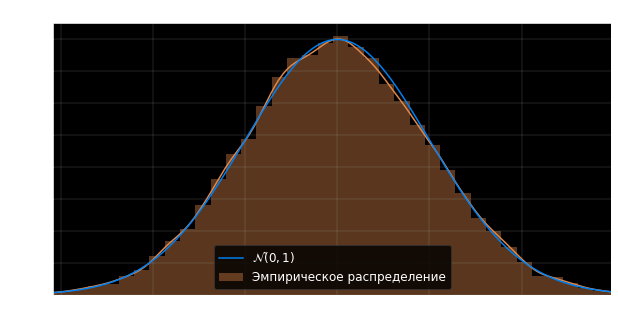

In [ ]:
numpy.random.seed(8)

sample_size=2000
M = 30000
sample_distr = norm(loc=5, scale=300)

T_X = lambda sample: numpy.sqrt(sample_size) * (numpy.mean(sample) - sample_distr.mean()) / numpy.std(sample, ddof=1)
T_sample = sample_statistics(
    number_of_experiments=M, statistic_function=T_X,
    sample_size=sample_size, sample_distr=sample_distr)

pyplot.figure(figsize=(10, 5))
l_bound, r_bound = numpy.quantile(T_sample, [0.001, 0.999])


x = numpy.linspace(l_bound, r_bound, 1000)
pyplot.title(f'Распределение статистики T(X), sample size={sample_size}', fontsize=12)
distplot(T_sample, label='Эмпирическое распределение')
pyplot.plot(x, norm(0, 1).pdf(x), label='$\mathcal{N}(0, 1)$')
pyplot.legend(fontsize=12)
pyplot.xlabel(f'{name}', fontsize=12)
pyplot.xlim((l_bound, r_bound))
pyplot.ylabel('Плотность', fontsize=12)
pyplot.grid(linewidth=0.2)
pyplot.show()

Тоже самое: статистика из нормального распределения! То есть в первый раз нам не повезло, что размер выборки был маленьким(

### Доверительный интервал

Выводится также, как и у t-test:

$CI_{\mu} = \left(\overline X \pm \dfrac{z_{1 - \alpha/2} \sqrt{S^2}}{\sqrt{n}} \right)$.


In [ ]:
sample = expon(scale=300).rvs(2000) # E sample = scale = 300
left_bound, right_bound = norm.interval(alpha=0.95, loc=numpy.mean(sample), scale=sem(sample))
print(f"CI = [{round(left_bound, 2)}, {round(right_bound, 2)}]")

CI = [289.96, 316.15]


----

Ну вот теперь кажется же самое время решать исходную задачу!

In [ ]:
left_bound, right_bound = norm.interval(alpha=0.95, loc=numpy.mean(profits), scale=sem(profits))
print(f"CI = [{round(left_bound, 2)}, {round(right_bound, 2)}]")

CI = [14.04, 102.94]


Да, выручка положительна! Значит мы нашли инвесторов для нашего стартапа :)

Единственное но: **а правда ли, что наша выборка достаточно большая? И T'-test тут работает?** Ответ на этот вопрос мы получим на следующем занятии.

## Какой критерий в итоге использовать на практике? T-test или T'-test?

Для начала определимся, когда какой критерий лучше использовать?

1. Если выборка размера 60, то уже $t_{59} \approx \mathcal{N}(0, 1)$.
    - Посмотрим на распределения Стьюдента и нормального:

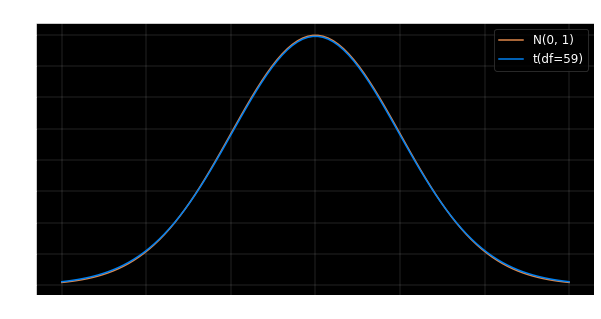

In [ ]:
df = 59
t_dist = t(df=df)
z_dist = norm(loc=0, scale=1)

x = numpy.linspace(-3, 3, 100)
pyplot.figure(figsize=(10, 5))
pyplot.title(f'Плотность распределения статистики T и N', fontsize=12)
pyplot.plot(x, z_dist.pdf(x), label='N(0, 1)')
pyplot.plot(x, t_dist.pdf(x), label=f't(df={df})')
pyplot.legend(fontsize=12)
pyplot.grid(linewidth=0.2)
pyplot.show()

- Мы видим, что эти 2 распределения визуально полностью совпадают, поэтому неважно, как посчитать: статистика $T\sim \mathcal{N}(0, 1)$ или $T\sim t_n$.
- **Но это не значит, что с N=60 T-test/T'-test работают корректно!** Если выборка не из нормального рапределения, они оба могут все еще ошибаться.

2. Если выборка меньше 60, то безопасней использовать t-test, нежели t'-test.
    - **У T-test FPR всегда будет меньше, чем у T'-test**.
        - На FPR влияет процент случаев `pvalue < alpha`. У t-test pvalue $\geq$ t'-test pvalue.
        - `pvalue = t_distr.cdf(x)` или `pvalue = norm_dist.cdf(x)`. Поэтому, чем тяжелее хвост у распределения, тем больше p-value. А теперь посмотрим на примере:

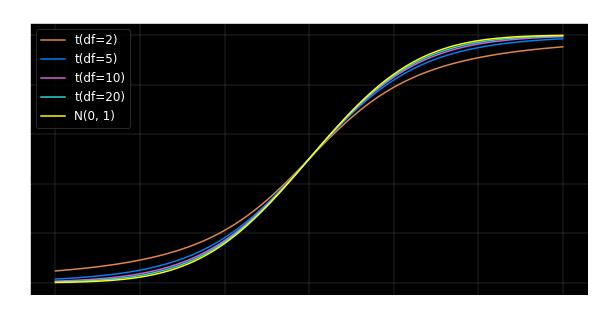

In [ ]:
df_array = [2, 5, 10, 20]
x = numpy.linspace(-3, 3, 100)

pyplot.figure(figsize=(10, 5))
pyplot.title(f'CDF распределений T и N', fontsize=12)
for df in df_array:
    t_dist = t(df=df)
    pyplot.plot(x, t_dist.cdf(x), label=f't(df={df})')

z_dist = norm(loc=0, scale=1)
pyplot.plot(x, z_dist.cdf(x), c='yellow', label='N(0, 1)')
pyplot.legend(fontsize=12)
pyplot.xlabel('X', fontsize=12)
pyplot.grid(linewidth=0.2)
pyplot.show()

Как видно на графике, чем меньше степень свободы, тем выше линия на графике (при x < 0), а значит и больше cdf при фиксированном x. Поэтому и p-value будет больше.


- Распределение Стьюдента с бесконечностью степеней свободы &mdash; это нормальное распределение: $t_{\infty} = \mathcal{N}(0, 1)$. Поэтому `norm(0, 1).cdf(x) = t_distr(df=infinity).cdf(x) < t_distr(df=N).cdf(x)`.

Поэтому, если выборка небольшая, безопаснее использовать t-test. Но все еще не факт, что ваш критерий будет валиден!

---

Посмотрим еще раз на табличку

|                          | маленькая выборка | большая выборка |
|--------------------------|-------------------|-----------------|
| нормальное распределение | t-test            | t-test, t'-test |
| любое распределение      |                   | t'-test, t-test |

Мы видим, что мы везде можем использовать t-test (а t'-test не всегда), и в случае маленьких выборок он безопаснее. **Поэтому t-test и стал намного более популярным, чем t'-test**. Но t'-test на практике может быть тоже полезен:
- Не надо думать при реализации о степенях свободы.
- Написать такой критерий на SQL будет сильно проще: вы можете использовать табличные значения в коде, чтобы понять, отвергся ли критерий.
- Делать различные теоретические вычисления проще.
- В нем сложнее ошибиться при реализации.



## MDE

Вернемся к задаче со стартапом. Представим, что мы хотим запустить наш стартап в новом городе, например в Санкт-Петербуре. **Вопрос: можем ли мы собрать выборку не из 2000 людей, как мы делали с Москвой, а всего из 1000?**

Что вообще нам мешает взять слишком маленькую выборку?
- Например, если мы проверяем наш стартап на 1-2 пользователей, то мы ничего не можем сказать про наш истинный эффект, он может быть как больше 0, так и меньше. Будет слишком широкий доверительный интервал (из-за большой дисперсии в выборке, как мы видели в Москве), и нам нужен огромный эффект, чтобы его обнаружить: например, 1М рублей прибыли.
    - Еще, возможно, мы не можем использовать критерий на такой маленькой выборке, но сейчас посчитаем, что t-test критерий валиден даже на маленькой выборке.
- А если выборка состояла бы из бесконечного числа пользователей, то мы могли бы абсолютно точно сказать истинную прибыль от пользователя, даже если она равна 1 копейке.
- Но оба эти случая нас не устраивают :( В первом - мы не сможем запустить стартап из-за слишком большого шума, а во втором - нам нужна вечность, чтобы проверить нашу гипотезу.

И здесь нам поможет MDE (minimum detectable effect). Это такое истинное значение эффекта, что наш шанс его обнаружить равен $1-\beta$ при использовании нашего критерия.
   - Мы можем посмотреть, какой эффект мы сможем задетектировать при доставке 1000 пользователям, и от этого решить, подходит нам такая выборка, или нет. Например:
        - Мы видим, что MDE 100 рублей. То есть с вероятностью $1-\beta$ (на практике 80%) мы его обнаружим, **если такой эффект будет**. И с вероятностью 80% стартап запустится в Питере. Отлично, это нас устраивает, мы проверяем гипотезу на 1000 человек.
        - Мы видим, что MDE 10000 рублей. Это, наоборот, слишком много: у нас 99% товаров стоят меньше 1000 рублей. Мы не наберем такой прибыли, стартап невыигрышный, нужно брать выборку большего размера.

---


От чего зависит MDE?
- Ошибка 1 рода, или $\alpha$.
    - Например, при $\alpha = 1$ мы найдем эффект и при размере выборки, равной 1 (мы просто всегда будем отвергать 0 гипотезу). А при $\alpha = 0$ мы никогда не задетектируем эффект.
- Мощность, или $1 - \beta$.
    - Следует из самого определения
- От шума в данных, или от дисперсии.
    - Чем более шумные данные, как мы знаем, тем шире доверительный интервал. А значит сложнее точно предсказать рамки для истинного эффекта, поэтому и MDE будет больше.
- От размера выборки.
    - Нас интересует не просто дисперсия в данных, а дисперсия среднего значения: она по той же логике должна быть как можно меньше. А что такое дисперсия среднего? Это $\dfrac{\sigma^2}{N}$, поэтому MDE также зависит от размера выборки.



Теперь давайте выведем формулу исходя из того, что мы знаем все эти 4 параметра.


-----
Для начала определимся с проверяемой гипотезой:  
- $H_0: \mu_0 = 0\ vs. \ H_1: \mu_0 > 0$

Обозначим
- $S^2_{\mu} := \dfrac{S^2}{N}$ &mdash; оценка дисперсии среднего значения.
- $S_{\mu} = \sqrt{\dfrac{S^2}{N}}$ &mdash; оценка стандартного отклонения среднего значения, или SEM.

Теперь, мы знаем, что
- $\overline X \sim \mathcal{N}(\mu, S^2_{\mu})$

Нам надо найти $MDE=m$, такое, что:

- если $\overline X \sim \mathcal{N}(m, S^2_{\mu})$, то в $1-\beta$ проценте случаев для него отвергнется критерий. Проверяем мощность (зеленая площадь на графике).
- если $\overline X \sim \mathcal{N}(0, S^2_{\mu})$, то критерий отвергнется для него в $\alpha$ процентов случаев. Проверяем FPR (красная площадь на графике).


<img src="https://raw.githubusercontent.com/dimalunin2016/pictures/main/download-3.png" width="1500" height="200" />



То есть:

- Пусть $B(X): P_{H_0}(\overline X > B(X)) = \alpha$. $B(X)$ &mdash; Граница критической области, красная граница на графике.
- Тогда $P_{H_1}(\overline X > B(X)) = 1-\beta$. Зеленая область на графике.
    - Или, что аналогично: $P_{H_1}(\overline X - m > B(X) - m) = 1-\beta$.
    - Обозначим $\xi := \overline X - m$. $P_{H_0}(\xi > B(X) - m) = 1-\beta$. Рыжая плотность получается из синей вычитанием m. $\xi$ из рыжей плотности, $\overline X$ из синей.

Надо решить эти 2 уравнения и мы получим выражение $m$ через все 4 параметра.

1. $B(X)$ мы итак знаем. При $H_0$ наш критерий имеет следующий вид: $\left\{T(X) \geq z_{1 - \alpha} \right\} \Leftrightarrow  \left\{\sqrt{N}\dfrac{\overline X}{\sqrt{S^2}} \geq z_{1 - \alpha} \right\} \Leftrightarrow B(X) = z_{1 - \alpha}\sqrt{\dfrac{S^2}{N}} = z_{1 - \alpha}S_{\mu} $

2. $P_{H_0}(\xi > z_{1 - \alpha}S_{\mu} - m) = 1-\beta$. Работать с распределением $\mathcal{N}(0, S^2_{\mu})$ не очень удобно, гораздо проще с $\mathcal{N}(0, 1)$. Для этого перехода достаточно перейти от $\xi \rightarrow \dfrac{\xi}{S_{\mu}}$ по свойствам нормального распределения.

- Обозначим $\eta := \dfrac{\xi}{S_{\mu}}$. Тогда
$$\begin{align}
    &P_{H_0}(\xi > z_{1 - \alpha}S_{\mu} - m) =\\
    &P_{H_0}(\dfrac{\xi}{S_{\mu}} > \dfrac{z_{1 - \alpha}S_{\mu} - m}{S_{\mu}}) =\\
    & P_{\mathcal{N}(0, 1)}(\eta > z_{1 - \alpha} - \dfrac{m}{S_{\mu}}) = 1-\beta
\end{align}
$$
- $\Phi(C) = P(\eta < C)$. Тогда
    $$\begin{align}
    &1 - \Phi \left(z_{1 - \alpha} - \dfrac{m}{S_{\mu}} \right) = 1-\beta \Leftrightarrow\\ &z_{1 - \alpha} - \dfrac{m}{S_{\mu}} = z_{\beta},
    \end{align}
    $$
    где $z_{\beta} = \Phi^{-1}(\beta)$ &mdash; квантиль $\beta$ нормального распределения.
    - В конце мы как раз пользуемся тем, что $\eta \sim \mathcal{N}(0, 1)$.
- Финально мы получаем, что: $m = (z_{1 - \alpha} - z_{\beta}) \cdot S_{\mu} = |\text{расп. симметрично}| = (z_{1 - \alpha} + z_{1 - \beta}) \cdot \sqrt{\dfrac{S^2}{N}}$.

### Итого:

- $\text{MDE} = (z_{1 - \alpha} + z_{1 - \beta}) \cdot \sqrt{\dfrac{S^2}{N}}$

----


Вернемся к стартапу. Мы определились, что N = 1000, $\alpha=5$%, $1-\beta=80$%, а как узнать $S^2$?

На практике есть 3 способа:
- Оценить на исторических данных. В данном случае это не подходит, потому что ранее стартапа в Питере не было.
- Оценить по похожим данным. Например, в нашем случае, оценить дисперисию по Москве.
- Как-то теоретически оценить. Самый плохой способ, который работает, если первые 2 не помогают.


Посмотрим теперь MDE в нашей задаче.

In [ ]:
N = 1000
S2 = numpy.var(profits)
alpha = 0.05
beta = 1 - 0.8

MDE = (norm().ppf(1-alpha) + norm().ppf(1 - beta)) * numpy.sqrt(S2/N)
print(f"MDE при N={N}: {MDE}")

MDE при N=1000: 126.08268390090282


А значит мы можем рассчитывать на точность лишь в 126 руб.

----
Для нас это слишком большой MDE: хочется, чтобы он был $\leq$ 100 рублей, мы предполагаем, что это более вероятный истинный эффект, исходя из опыта с Москвой.


Давайте теперь решим обратную задачу: Мы знаем MDE=100руб, $\alpha=5$%, $1-\beta=80$%, $S^2$, чему равно $N$? Выведем его из формулы MDE:

$N = \left(\dfrac{z_{1 - \alpha} + z_{1 - \beta}}{\text{MDE}}\right)^2 S^2$

In [ ]:
S2 = numpy.var(profits)
alpha = 0.05
beta = 1 - 0.8
mde = 100

N = ((norm().ppf(1-alpha) + norm().ppf(1 - beta)) / mde)**2 * S2
N = int(N) + 1
print(f'Минимальный размер выборки: {N}')

Минимальный размер выборки: 1590


Тогда нам надо взять выборку размера примерно 1600 человек.

Таким образом, сделав подготовительную работу, мы поняли, что 1000 человек это мало, 2000 человек &mdash; много для нашего MDE. И подобрали иделаьный размер выборки.

# Двувыборочный T-test. Задача AB-тестирования

> 📈 **Задача**
>
> У нас на сайте Авито есть услуги продвижения. Мы хотим начать давать на них скидки, чтобы привлечь больше людей и начать больше зарабатывать. Для этого было решено провести AB тест:
> Одной половине пользователей мы не выдали скидок, а во второй половине мы выдали скидки всем новым пользователям. Надо понять, стали ли мы больше зарабатывать?


Для решения этой задачи мы не можем использовать одновыборочный t-test. В этот раз у нас 2 выборки $A$ &mdash; контроль, и $B$ &mdash; тест.

Наша гипотеза звучит так:
$H_0: E A = E B\ vs. H_1: E A < E B$

1. **Обе выборки нормальны**. Тогда есть 2 критерия в зависимости от наших знаний про дисперсию:
    - $\sigma^2_A = \sigma^2_B$.
    
    Тогда:
        - $S^2_{full} = \dfrac{(N - 1)S^2_A + (M - 1)S^2_B}{N + M - 2}$, где N, M -  размер контроля и теста соотвественно. А критерий выглядит следующим образом:
        - $T(A, B) = \dfrac{\overline A - \overline B}{S^2_{full}\sqrt{1/N + 1/M}} \overset{H_0}{\sim} T_{n + m - 2}$
   
    - $\sigma^2_A \neq \sigma^2_B$.
    
    Тогда:
        - $T(A, B) = \dfrac{\overline A - \overline B}{\sqrt{S^2_{A}/N + S^2_{B}/M}} \overset{H_0}{\sim} T_{v}$
            - где $v = \dfrac{\left(\dfrac{S^2_{A}}{N} + \dfrac{S^2_{B}}{M} \right)^2}{\left(\dfrac{(S^2_{A})^2}{N^2(N - 1)} + \dfrac{(S^2_{B})^2}{M^2(M-1)} \right)} $
2. **Хотя бы 1 выборка ненормальна**. Тогда вбой вступает нормальная аппроксимация при большом размере выборок, критерий T'-test:
    - $T(A, B) = \dfrac{\overline A - \overline B}{\sqrt{S^2_{A}/N + S^2_{B}/M}} \overset{H_0}{\sim} \mathcal{N}(0, 1)$
    - Согласитесь, здесь намного проще формула, чем те, что выше? :) Поэтому для AB-тестирования самостоятельно легче реализовать именно t'-критерий, где вы не ошибетесь.
    
    
-----

Python-библиотеки:

- `scipy.stats.ttest_ind` &mdash; 2-выборочный t-test [критерий](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html#scipy.stats.ttest_ind)
- `CompareMeans` &mdash; [класс](https://www.statsmodels.org/stable/generated/statsmodels.stats.weightstats.CompareMeans.html) для построения доверительных интервалов у t-test.

In [ ]:
numpy.random.seed(42)
X = expon(scale=1100).rvs(1000)
Y = norm(loc=980, scale=30).rvs(1000)

ttest_ind(X, Y, equal_var=False, alternative='greater')

Ttest_indResult(statistic=2.5645688722251325, pvalue=0.005237676356845092)

In [ ]:
ttest_ind(X, Y, equal_var=False).pvalue

0.010475352713690184

In [ ]:
# Доверительный интервал

cm = CompareMeans(DescrStatsW(X), DescrStatsW(Y))
print(cm.tconfint_diff(usevar='unequal'))

(20.380593037118373, 153.1987434094658)


# О чем важно помнить

При использовании t-test критериев, как одновыборочного, так и двувыборочного, важно помнить, что:

- **Элементы выборок должны быть независимы!**
    - Например, ваша выборка не можеть содержать несколько заказов одного пользователя. Они должны быть агрегированны, иначе критерии будут невалидны!
- В двубырочном критерии **выборки теста и контроля должны быть независимы!**
    - Иначе критерии точно также будут невалидны.
    
Более подробно к чему приводят ошибки с независимостью выборок мы рассмотрим на следующих лекциях.

## Итог

На этой лекции мы рассмотрели
- Как строить критерии для оценки среднего в случае, если вы не знаете дисперсии изначального распределения?
    
|                          | маленькая выборка | большая выборка |
|--------------------------|-------------------|-----------------|
| нормальное распределение | t-test               | t-test, t'-test |
| любое распределение      |  | t'-test, t-test |


- Вывели доверительные интервалы 2-мя способами.
- Показали, что по умолчанию лучше использовать T-test, как более безопасный критерий.
- Вывели формулу MDE для одновыборочного критерия.
    - А также ввели формулу для минимального размера выборки.
- Посмотрели, какие есть критерии для AB-тестирования.
- Уточнили, какие условия нужно наложить на выборку, чтобы критерии можно было бы корректно применять.

## Доп секция

### Как выбрать $S^2$?

В начале лекции мы взяли $\widehat{\sigma^2} = S^2 = \dfrac{1}{n - 1}\underset{i=1}{\overset{n}{\sum}}(X_i - \overline X)^2$. А можно ли брать другую статистику для оценки дисперсии?

- Для T-test нет, там все фиксировано. Теоретическая формула с t-распределением подходит только для описанной оценки дисперсии.
- Для T'-test же все проще: *мы можем взять любую оценку* $\widehat{\sigma^2}$, которая является состоятельной оценкой $\sigma^2$.
    - В этом случае, проведя то же док-во, которое мы выводили ранее для T'-критерия, мы получим, что точно также $T(X) = \sqrt{n}\dfrac{\overline X - \mu_0}{\widehat{\sigma^2}} \rightarrow \mathcal{N}(0, 1)$. Так что при больших N неважно, какую состоятельную оценку дисперсии брать.
    - Какие оценки являются состоятельными?
        - $\widehat{\sigma^2} = \dfrac{1}{n}\underset{i=1}{\overset{n}{\sum}}(X_i - \overline X)^2$
        - $\widehat{\sigma^2} = \dfrac{1}{n + 1}\underset{i=1}{\overset{n}{\sum}}(X_i - \overline X)^2$
        - Так что неважно, на что вы делите: на $\dfrac{1}{n}$ или $\dfrac{1}{n-1}$, при больших n нет разницы.
        


       
### Смысл степени свободы

Давайте разбираться, что это за зверь такой. Для начала мы поймем, как оно работает для хи квадрат:

1. $\eta = \dfrac{(n - 1)\cdot S^2_X}{\sigma^2} = \underset{i=1}{\overset{n}{\sum}}\left(\xi_i - \overline \xi \right)^2 \sim \chi^2_{n-1}$, где $\xi_i \sim \mathcal{N}(0, 1)$
    
    - Вспомним, что $\underset{i=1}{\overset{n}{\sum}}\left(\xi_i - \mu \right)^2 = \underset{i=1}{\overset{n}{\sum}}\xi_i^2 \sim \chi^2_n$, это одно из возможных определей $\chi_2$. И тут степеней свободы равно числу независимых параметров в системе: n. Каждое $\xi_i$ случайно и не зависит от остальных.
    - Но как только мы заменяем $\mu$ на $\overline \xi$, то мы говорим, что мы фиксируем $\overline \xi$. Так что теперь наши $\xi_i$ такие, что они дали оценку $\mu$ как $\overline \xi$ и никакую другую.
    - А если мы знаем среднее случайных величин, то теперь мы можем свободно менять лишь $n-1$ значение $\xi_i: i \in {1, ..., n-1}$. Оставшееся значение зафиксировано, и напрямую считается из среднего и n-1 оставшегося значения.



2. $T = \sqrt{n}\dfrac{\overline X - \mu_0}{\sqrt{S^2}} = \dfrac{\xi}{\sqrt{\dfrac{\eta}{n-1}}} \sim t_{n - 1}$
    - Здесь степень свободы также берется из хи-квадрат, у которого она такая, потому что мы оценили мат. ож и на это потратили 1 степень свободы.

**Итого** простая интерпретация степени свободы &mdash; число свободно меняемых параметров в статиcтике.